## **Parallelization Workflow**


In [13]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from typing_extensions import TypedDict, Literal, Annotated, List
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

In [14]:
# llm schema
class llm_schema(BaseModel):
    topic: str = Field(...,
                       description="The topic of the post to be generated")
    category: Literal["twitter", "linkedin", "blog"] = Field(
        ..., description="The category of the post to be generated")

In [15]:
llm = ChatGroq(model="openai/gpt-oss-120b")

# returns pydantic object
llm_with_schema = llm.with_structured_output(llm_schema)
# returns dictionary
# llm_with_schema = llm.with_structured_output(llm_schema.model_json_schema())

In [16]:
# llm_with_schema.invoke("I want to generate a post about EVs for blog")

In [17]:
# graph schema
class AgentState(TypedDict):
    user_input: str
    topic: str
    post: str

    category: str

In [18]:
# category decider node

def category_decider(state: AgentState):
    user_input = state["user_input"]

    response = llm_with_schema.invoke(user_input)

    return {"category": response.category, "topic": response.topic}

In [ ]:
# linkedin post node
def linkedin_post_node(state: AgentState):
    topic = state["topic"]

    prompt = ChatPromptTemplate.from_messages([
        ('system', 'You are a LinkedIn post generator. Keep the tone professional and informative.'),
        ('human', '{topic}'),
    ])

    chain = prompt | llm

    response = chain.invoke({"topic": topic})

    return {"post": response.content}


# twitter post node
def twitter_post_node(state: AgentState):
    topic = state["topic"]

    prompt = ChatPromptTemplate.from_messages([
        ('system', 'You are a Twitter post generator. Keep the tone casual and engaging.'),
        ('human', '{topic}'),
    ])

    chain = prompt | llm

    response = chain.invoke({"topic": topic})

    return {"post": response.content}


# blog post node
def blog_post_node(state: AgentState):
    topic = state["topic"]

    prompt = ChatPromptTemplate.from_messages([
        ('system', 'You are a blog post generator. generate a detailed and informative blog post about various topics in 300 words only.'),
        ('human', '{topic}'),
    ])

    chain = prompt | llm

    response = chain.invoke({"topic": topic})

    return {"post": response.content}

In [20]:
# router node
def router_node(state: AgentState):
    category = state["category"]

    if category == "linkedin":
        return "linkedin_post_node"
    elif category == "twitter":
        return "twitter_post_node"
    elif category == "blog":
        return "blog_post_node"
    else:
        raise ValueError("Invalid category")

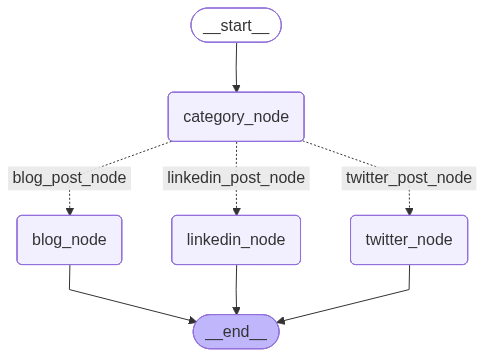

In [21]:
graph = StateGraph(AgentState)

graph.add_node("category_node", category_decider)
graph.add_node("twitter_node", twitter_post_node)
graph.add_node("linkedin_node", linkedin_post_node)
graph.add_node("blog_node", blog_post_node)

graph.add_edge(START, "category_node")
graph.add_conditional_edges(
    "category_node",
    router_node,
    {
        "linkedin_post_node": "linkedin_node",
        "twitter_post_node": "twitter_node",
        "blog_post_node": "blog_node"
    }
)

app = graph.compile()
app

In [22]:
response = app.invoke({
    "user_input": "I want to generate a post about combustion for medium article",
    "topic": "",
    "category": "",
    "post": "",
})

In [23]:
print(response["post"])

**Combustion: The Fire That Powers Modern Life**

Combustion—often simply called burning—is a rapid oxidation reaction that releases heat, light, and a suite of chemical products. At its core, the process follows the equation *Fuel + O₂ → CO₂ + H₂O + energy*. While the chemistry is straightforward, the implications stretch across energy production, transportation, industry, and the environment.

**1. The Chemistry Behind the Flame**  
When a fuel molecule contacts oxygen, its bonds break and reform into more stable carbon‑dioxide and water molecules. The excess energy from this rearrangement appears as thermal energy, which can be harnessed for work. Key parameters that govern combustion efficiency include temperature, pressure, and the fuel‑to‑air ratio. Too much or too little oxygen produces incomplete combustion, generating carbon monoxide, soot, and unburned hydrocarbons.

**2. Types of Combustion**  
- *Premixed combustion*: Fuel and oxidizer mix before ignition (e.g., gasoline en

In [24]:
response

{'user_input': 'I want to generate a post about combustion for medium article',
 'topic': 'combustion',
 'post': '**Combustion: The Fire That Powers Modern Life**\n\nCombustion—often simply called burning—is a rapid oxidation reaction that releases heat, light, and a suite of chemical products. At its core, the process follows the equation\u202f*Fuel\u202f+\u202fO₂\u202f→\u202fCO₂\u202f+\u202fH₂O\u202f+\u202fenergy*. While the chemistry is straightforward, the implications stretch across energy production, transportation, industry, and the environment.\n\n**1. The Chemistry Behind the Flame**  \nWhen a fuel molecule contacts oxygen, its bonds break and reform into more stable carbon‑dioxide and water molecules. The excess energy from this rearrangement appears as thermal energy, which can be harnessed for work. Key parameters that govern combustion efficiency include temperature, pressure, and the fuel‑to‑air ratio. Too much or too little oxygen produces incomplete combustion, generati